In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.core import Dense
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from agent.mcts import ChessMonteCarloTreeSearch
from agent.predict import MovePredictor
from chess_environment.position_parser import ChessPositionParser

import config

np.random.seed(123)

cfg = config.Config()

Using Theano backend.


In [2]:
# Read in training data
dfs_tr = []
dfs_cv = []

for f in glob.glob(os.path.join(cfg.resources.move_data_directory, '*_tr.csv')):
    dfs_tr.append(pd.read_csv(f))
    
for f in glob.glob(os.path.join(cfg.resources.move_data_directory, '*_cv.csv')):
    dfs_cv.append(pd.read_csv(f))
    
df_tr = pd.concat(dfs_tr)
df_cv = pd.concat(dfs_cv)

print(df_tr)
print(df_cv)

                                                    fen move_0 move_1 move_2  \
0     rnbq1rk1/ppp2ppp/3b1n2/3p4/3P4/5N2/PPP1BPPP/RN...   c1g5   c2c3   c2c4   
1     rnbq1rk1/ppp2ppp/3b1n2/3p4/3P4/5N2/PPP1BPPP/RN...   c2c4   c2c3   h2h3   
2     rnbq1rk1/ppp2ppp/3b1n2/3p4/3P4/5N2/PPP1BPPP/RN...   c1g5   b1c3   c2c4   
3     rn1qkbnr/ppp1pppp/4b3/8/2pP4/2N1P3/PP3PPP/R1BQ...   g8f6   c7c6   b8c6   
4     rn1qkbnr/ppp1pppp/4b3/8/2pP4/2N1P3/PP3PPP/R1BQ...   c7c6   g8f6   g8h6   
5     rn1qkbnr/ppp1pppp/4b3/8/2pP4/2N1P3/PP3PPP/R1BQ...   g8f6   b8c6   g7g6   
6     rnbqkbnr/pp1p1ppp/4p3/8/2B1P3/2N5/PP3PPP/R1BQK...   b8c6   a7a6   f8b4   
7     rnbqkbnr/pp1p1ppp/4p3/8/2B1P3/2N5/PP3PPP/R1BQK...   a7a6   b8c6   f8b4   
8     rnbqkbnr/pp1p1ppp/4p3/8/2B1P3/2N5/PP3PPP/R1BQK...   a7a6   b8c6   f8b4   
9     r1bqkb1r/pppp1Bpp/2n5/4p3/4n3/2N2N2/PPPP1PPP/R...   e8f7   e8e7    NaN   
10    r1bqkb1r/pppp1Bpp/2n5/4p3/4n3/2N2N2/PPPP1PPP/R...   e8f7   e8e7    NaN   
11    r1bqkb1r/pppp1Bpp/2n5/4p3/4n3/2N2N

In [3]:
# Process and augment data
def process_and_augment(df, augmentation_factor=10, candidate_moves=20, eval_depths=(1, 3, 7, 10)):
    # Get the different types of features as np arrays so they can be shuffled
    priors = df.filter(regex='prior_.*').values
    evals = df.filter(regex='eval_.*').values
    elos = df.filter(regex='elo').values
    
    y = df.filter(regex='actual_freq_.*').values
    
    # Reshape evals so that depth is in the third dimension
    evals = evals.reshape((-1, candidate_moves, len(eval_depths)))
    
    # Create random permutations for the moves
    permutations = [np.random.permutation(candidate_moves) for _ in range(augmentation_factor)]
    
    priors = np.concatenate([priors[:, p] for p in permutations])
    evals = np.concatenate([evals[:, p, :] for p in permutations])
    elos = np.concatenate([elos[:] for _ in permutations])
    
    y = np.concatenate([y[:, p] for p in permutations])
    
    # Flatten evals back to 2 dimensions
    evals = evals.reshape((-1, candidate_moves * len(eval_depths)))
    
    X = np.concatenate([priors, evals, elos], axis=1)
    
    return X, y

In [4]:
X, y = process_and_augment(df_tr, augmentation_factor=30, 
                           candidate_moves=cfg.move_probability_model.num_candidate_moves,
                           eval_depths=cfg.move_probability_model.valuation_depths)

X_cv, y_cv = process_and_augment(df_cv, augmentation_factor=5, 
                                 candidate_moves=cfg.move_probability_model.num_candidate_moves,
                                 eval_depths=cfg.move_probability_model.valuation_depths)

In [5]:
# Build our model
model_config = cfg.move_probability_model
input_layer = model = Input((model_config.input_size,))

# Build dense layers
for index, size in enumerate(model_config.dense_layer_sizes):
    
    layer_name = 'dense{}'.format(index)
    model = Dense(size, kernel_regularizer=l2(model_config.l2_reg), activation='sigmoid', name=layer_name)(model)

# Move Probability Output
model_out = Dense(model_config.num_candidate_moves, kernel_regularizer=l2(model_config.l2_reg),
                  activation='softmax', name='output')(model)

model = Model(input_layer, model_out, name='chess_move_model')

# Compile Model
model.compile(optimizer=Adam(), loss='categorical_crossentropy')

In [6]:
# Traing Model on small set of samples as a sanity check. 
# For 20 classes, we would expect a uniform guess to have a loss of ln(20) ~ 3
model.fit(x=X[100:101], y=y[100:101], validation_data=(X_cv[:1], y_cv[:1]), batch_size=1, epochs=100, verbose=2)

Train on 1 samples, validate on 1 samples
Epoch 1/100
 - 0s - loss: 3.1433 - val_loss: 3.2991
Epoch 2/100
 - 0s - loss: 2.8492 - val_loss: 3.2621
Epoch 3/100
 - 0s - loss: 2.5646 - val_loss: 3.2372
Epoch 4/100
 - 0s - loss: 2.2917 - val_loss: 3.2264
Epoch 5/100
 - 0s - loss: 2.0331 - val_loss: 3.2316
Epoch 6/100
 - 0s - loss: 1.7921 - val_loss: 3.2554
Epoch 7/100
 - 0s - loss: 1.5718 - val_loss: 3.2997
Epoch 8/100
 - 0s - loss: 1.3750 - val_loss: 3.3656
Epoch 9/100
 - 0s - loss: 1.2039 - val_loss: 3.4530
Epoch 10/100
 - 0s - loss: 1.0594 - val_loss: 3.5604
Epoch 11/100
 - 0s - loss: 0.9409 - val_loss: 3.6845
Epoch 12/100
 - 0s - loss: 0.8468 - val_loss: 3.8215
Epoch 13/100
 - 0s - loss: 0.7741 - val_loss: 3.9668
Epoch 14/100
 - 0s - loss: 0.7195 - val_loss: 4.1160
Epoch 15/100
 - 0s - loss: 0.6792 - val_loss: 4.2652
Epoch 16/100
 - 0s - loss: 0.6500 - val_loss: 4.4113
Epoch 17/100
 - 0s - loss: 0.6291 - val_loss: 4.5519
Epoch 18/100
 - 0s - loss: 0.6141 - val_loss: 4.6853
Epoch 19/100


In [7]:
# Train Model
checkpoint_cb = ModelCheckpoint(filepath=cfg.resources.best_move_model_path,
                                save_best_only=True,
                                mode='min',
                                monitor='val_loss')

history = model.fit(x=X, y=y, validation_data=(X_cv, y_cv), callbacks=[checkpoint_cb], 
                    batch_size=4096, epochs=25, verbose=2)

Train on 1720320 samples, validate on 286720 samples
Epoch 1/25
 - 19s - loss: 2.6484 - val_loss: 2.5667
Epoch 2/25
 - 18s - loss: 1.7665 - val_loss: 2.1967
Epoch 3/25
 - 18s - loss: 1.6554 - val_loss: 2.1451
Epoch 4/25
 - 20s - loss: 1.6229 - val_loss: 2.0968
Epoch 5/25
 - 19s - loss: 1.6051 - val_loss: 2.0470
Epoch 6/25
 - 17s - loss: 1.5934 - val_loss: 2.0210
Epoch 7/25
 - 18s - loss: 1.5857 - val_loss: 2.0098
Epoch 8/25
 - 18s - loss: 1.5802 - val_loss: 1.9814
Epoch 9/25
 - 18s - loss: 1.5760 - val_loss: 1.9622
Epoch 10/25
 - 17s - loss: 1.5728 - val_loss: 1.9619
Epoch 11/25
 - 18s - loss: 1.5704 - val_loss: 1.9550
Epoch 12/25
 - 18s - loss: 1.5683 - val_loss: 1.9507
Epoch 13/25
 - 18s - loss: 1.5667 - val_loss: 1.9589
Epoch 14/25
 - 17s - loss: 1.5652 - val_loss: 1.9639
Epoch 15/25
 - 18s - loss: 1.5639 - val_loss: 1.9583
Epoch 16/25
 - 22s - loss: 1.5628 - val_loss: 1.9477
Epoch 17/25
 - 21s - loss: 1.5617 - val_loss: 1.9375
Epoch 18/25
 - 19s - loss: 1.5607 - val_loss: 1.9401
Ep

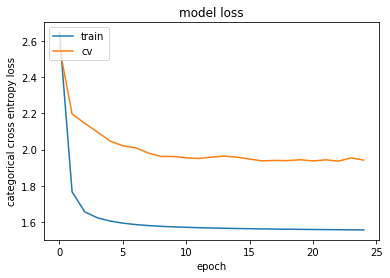

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

In [6]:
# Load up the trained model
move_predictor = MovePredictor(cfg)
position_parser = ChessPositionParser(cfg, [], [])

# Englund
fen = 'r1b1kbnr/pppp1ppp/2n5/4P3/1q3B2/5N2/PPP1PPPP/RN1QKB1R w KQkq - 5 5'

player_elo = 3000
opponent_elo = 3000
time_control = '3600+30'
num_simulations = 50

deterministic_moves = {
    'r1b1kbnr/pppp1ppp/2n5/4P3/1q3B2/2N2N2/PPP1PPPP/R2QKB1R b KQkq -': 'Qxb2',
    'r1b1kbnr/pppp1ppp/2n5/4P3/8/2N2N2/PqPBPPPP/R2QKB1R b KQkq -': 'Nb4',
    'r1b1kbnr/pppp1ppp/8/4P3/1n1N4/2N5/PqPBPPPP/R2QKB1R b KQkq -': 'c6',
    'r1b1kbnr/pppp1ppp/8/4P3/1n6/2N2N2/PqPBPPPP/2RQKB1R b Kkq -': 'Nxa2',
    'r1b1kbnr/pppp1ppp/8/4P3/1n6/2N2N2/PqPBPPPP/1R1QKB1R b Kkq -': 'Nxc2',
    'r1b1kbnr/pppp1ppp/2n5/4P3/1q6/5N2/PPPBPPPP/RN1QKB1R b KQkq -': 'Qxb2',
    'r1b1kbnr/pppp1ppp/2n5/4P3/8/2B2N2/PqP1PPPP/RN1QKB1R b KQkq -': 'Bb4',
    'r1b1k1nr/pppp1ppp/2n5/4P3/1b6/2B2N2/PqPQPPPP/RN2KB1R b KQkq -': 'Bxc3',
    'r1b1k1nr/pppp1ppp/2n5/4P3/8/2Q2N2/PqP1PPPP/RN2KB1R b KQkq -': 'Qc1',
    'r1b1kbnr/pppp1ppp/2n5/4P3/1q3B2/5N2/PPPQPPPP/RN2KB1R b KQkq -': 'Qxb2',
    'r1b1kbnr/pppp1ppp/2n5/4P3/5B2/2Q2N2/PqP1PPPP/RN2KB1R b KQkq -': 'Bb4',
}

mcts = ChessMonteCarloTreeSearch(cfg, move_predictor, position_parser, num_simulations=num_simulations,
                                 player_elo=player_elo, opponent_elo=opponent_elo, fen=fen, 
                                 deterministic_moves=deterministic_moves)

j = mcts.run_search().get_json(max_depth=6)

with open('/Users/tom/Projects/Portfolio/web-static/public/chess/englund-engine-tree-3000.json', 'w') as f:
    print(j, file=f)